In [27]:
import numpy as np
import pandas as pd
import glob
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, make_scorer
from sklearn.preprocessing import *
from sklearn.model_selection import *

import warnings
warnings.filterwarnings("ignore")

my_random_state = 2022

In [11]:
path = "/Users/sunshangwen/Dropbox (Personal)/Mac/Desktop/Git Uploads/MTH-9899-Data-Science-II-Project/merged_data.csv"
merged = pd.read_csv(path, sep = ",")

In [13]:
use_cols = ["Date", "Time", "Id", "ResidualNoWinsorCumReturn winsorized", "RawNoWinsorCumReturn winsorized",
           "estVol winsorized", "SharesOutstanding winsorized", "MDV_63 winsorized", "CleanMid winsorized",
           "CumVolume winsorized"]
merged = merged[use_cols]
merged.head(10)

,Date,Time,Id,ResidualNoWinsorCumReturn winsorized,RawNoWinsorCumReturn winsorized,estVol winsorized,SharesOutstanding winsorized,MDV_63 winsorized,CleanMid winsorized,CumVolume winsorized
0,20140102,10:00:00.000,IDZQ0003GF7,0.008795,0.008043,0.093123,110.580,4321539.0,32.009570,30851.0
1,20140102,10:00:00.000,IDZQ00047M8,-0.007513,-0.008949,0.129865,449.750,7728599.0,5.929723,100377.0
2,20140102,10:00:00.000,IDZQ00048R1,0.002052,0.001240,0.151308,227.481,34529812.0,46.881290,118814.0
3,20140102,10:00:00.000,IDZQ0005R34,-0.007269,-0.006079,0.122016,575.375,2318102.2,6.155510,57972.0
4,20140102,10:00:00.000,IDZQ0005SC2,-0.004682,-0.009140,0.066838,839.394,66501836.0,27.234093,399523.0
5,20140102,10:00:00.000,IDZQ0007ZC4,0.003457,0.002491,0.116665,257.146,15165916.0,12.642498,63488.0
6,20140102,10:00:00.000,IDZQ0008WW8,-0.004565,-0.006895,0.200375,1199.193,20980068.0,8.053623,792118.0
7,20140102,10:00:00.000,IDZQ0009HH7,0.001507,0.003108,0.150383,49.760,10001647.0,83.713650,57225.0
8,20140102,10:00:00.000,IDZQ0009P98,-0.008188,-0.005854,0.097242,120.265,13023300.0,52.391100,26265.0
9,20140102,10:00:00.000,IDZQ000BBR6,0.006872,0.001722,0.101256,1022.341,47041750.0,17.876140,458629.0


In [117]:
train = merged[merged["Date"] < 20170101]
#validation = merged[(merged["Date"] >= 20160101) & (merged["Date"] < 20170101)]
test = merged[merged["Date"] >= 20170101]

X_train = train[["estVol winsorized", "SharesOutstanding winsorized", "MDV_63 winsorized", "CleanMid winsorized",
           "CumVolume winsorized"]]
y_train = train["ResidualNoWinsorCumReturn winsorized"]
X_test = test[["estVol winsorized", "SharesOutstanding winsorized", "MDV_63 winsorized", "CleanMid winsorized",
           "CumVolume winsorized"]]
y_test = test["ResidualNoWinsorCumReturn winsorized"]

In [118]:
# scale the features in train set
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_train_scaled = pd.DataFrame(data = X_train_scaled, columns = X_train.columns)

# do the same scaling to test set
X_test_scaled = sc.transform(X_test)
X_test_scaled = pd.DataFrame(data = X_test_scaled, columns = X_test.columns)

In [134]:
def my_own_scorer(X_):
    # note that feature estVol should always be set as the first column to 
    # make sure the expected weighted r2 score
    r2_weight = np.array(X_.iloc[:, 0])
    r2_weight = r2_weight / r2_weight.sum()
    return make_scorer(r2_score, sample_weight = r2_weight)

In [175]:
def regmodel_hyperparameter_tuning(alphas_to_try, X, y, cv = 3, scoring = 'weighted r2', model_name = 'Ridge', 
                        X_test = None, y_test = None, draw_plot = False, filename = None):
    
    # tuning the hyper-parameter by grid searching
    # optimising on one basis but then comparing performance on another
    # scoring method: weighted R-squared
    validation_scores = []
    train_scores = []
    results_list = []
    
    tscv = TimeSeriesSplit(n_splits = cv)
    
    def my_own_scorer(X_):
        # note that feature estVol should always be set as the first column to 
        # make sure the expected weighted r2 score
        
        r2_weight = 1 / np.array(X_.iloc[:, 0])
        r2_weight = r2_weight / r2_weight.sum()
        #scoring_ = {scoring: make_scorer(r2_score, sample_weight = r2_weight),
        #   'r2': make_scorer(r2_score)
        #   }
        return make_scorer(r2_score, sample_weight = r2_weight) # return a scorer
        #return make_scorer(r2_score)
    
    
    
    if X_test is not None:
        test_scores = []
        scorer_test = get_scorer(my_own_scorer(X_test)) ######################
    else:
        test_scores = None

    for curr_alpha in alphas_to_try:
        
        if model_name == 'Lasso':
            regmodel = Lasso(alpha = curr_alpha)
            
        elif model_name == 'Ridge':
            regmodel = Ridge(alpha = curr_alpha)
            
        elif model_name == 'SimpleLR':
            regmodel = LinearRegression()
            
        else:
            return None
        
        scorer_train = my_own_scorer(X) #######################
        results = cross_validate(regmodel, X, y, scoring = scorer_train, cv = tscv, return_train_score = True)
        print(results)
        validation_scores.append(np.mean(results['test_score']))
        train_scores.append(np.mean(results['train_score']))
        results_list.append(results)

        if X_test is not None:
            regmodel.fit(X,y)
            y_pred = regmodel.predict(X_test)
            test_scores.append(scorer_test(regmodel, X_test, y_test)) #######################
            

    chosen_alpha_id = np.argmax(validation_scores)
    chosen_alpha = alphas_to_try[chosen_alpha_id]
    max_validation_score = np.max(validation_scores)
    
    if X_test is not None:
        test_score_at_chosen_alpha = test_scores[chosen_alpha_id]
    else:
        test_score_at_chosen_alpha = None
        
    if draw_plot:
        regmodel_param_plot(validation_scores, train_scores, alphas_to_try, chosen_alpha, 
                            model_name, scoring, test_scores, filename)
        
    print("Chosen alpha: %.5f" % chosen_alpha)
    print("Validation score: %.5f" % max_validation_score)
    print("Test score at chosen alpha: %.5f" % test_score_at_chosen_alpha)
    
    return chosen_alpha, max_validation_score, test_score_at_chosen_alpha



def regmodel_param_plot(validation_score, train_score, alphas_to_try, chosen_alpha, scoring,
                        model_name, test_score = None, filename = None):
    
    plt.figure(figsize = (8,8))
    sns.lineplot(y = validation_score, x = alphas_to_try, label = 'validation_data')
    sns.lineplot(y = train_score, x = alphas_to_try, label = 'training_data')
    plt.axvline(x = chosen_alpha, linestyle = '--')
    
    if test_score is not None:
        sns.lineplot(y = test_score, x = alphas_to_try, label = 'test_data')
        
    plt.xlabel('alpha_parameter')
    plt.ylabel(scoring)
    plt.title(model_name + ' Regularization')
    plt.legend()
    
    if filename is not None:
        plt.savefig(str(filename) + ".png")
        
    plt.show()

{'fit_time': array([ 2.78808689,  6.87484002, 11.40466285]), 'score_time': array([0.0123632 , 0.00760913, 0.00952411]), 'test_score': array([nan, nan, nan]), 'train_score': array([nan, nan, nan])}
{'fit_time': array([0.05565906, 0.09150505, 0.08087897]), 'score_time': array([0.00576901, 0.00385594, 0.00346518]), 'test_score': array([nan, nan, nan]), 'train_score': array([nan, nan, nan])}
{'fit_time': array([0.03527713, 0.0659101 , 0.08694196]), 'score_time': array([0.00359607, 0.0040729 , 0.00493479]), 'test_score': array([nan, nan, nan]), 'train_score': array([nan, nan, nan])}
{'fit_time': array([0.04699922, 0.08809185, 0.09961796]), 'score_time': array([0.00454283, 0.00529933, 0.0047152 ]), 'test_score': array([nan, nan, nan]), 'train_score': array([nan, nan, nan])}
{'fit_time': array([0.04334521, 0.08225489, 0.08853197]), 'score_time': array([0.00401211, 0.00394893, 0.00397396]), 'test_score': array([nan, nan, nan]), 'train_score': array([nan, nan, nan])}
{'fit_time': array([0.04641

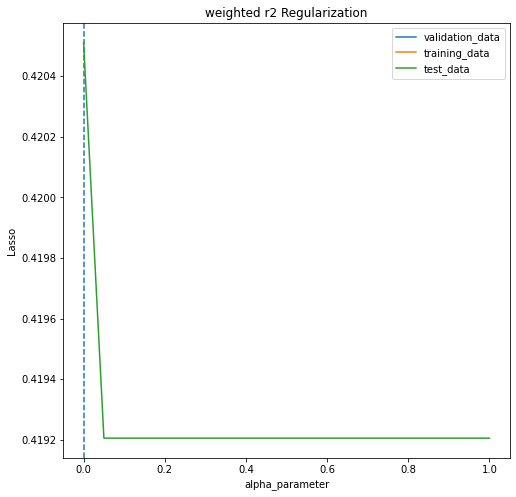

Chosen alpha: 0.00000
Validation score: nan
Test score at chosen alpha: 0.42051


(0.0, nan, 0.42050981204399307)

In [176]:
# wide search
# lasso model
lasso_alphas = np.linspace(0, 1, 21)
tscv = TimeSeriesSplit(n_splits=3)
regmodel_hyperparameter_tuning(lasso_alphas, X_train_scaled, y_train, 
                               cv = 3, model_name = 'Lasso', X_test = X_test_scaled, y_test = y_test, 
                               draw_plot = True, filename = 'lasso_wide_search')

In [162]:
from sklearn.metrics import make_scorer
from sklearn.svm import SVR

import numpy as np

rng = np.random.RandomState(1)

def my_custom_loss_func(X_train_scaled, Y_train_scaled):
    error, M = 0, 0
    for i in range(0, len(Y_train_scaled)):
        z = (Y_train_scaled[i] - M)
        if X_train_scaled[i] > M and Y_train_scaled[i] > M and (X_train_scaled[i] - Y_train_scaled[i]) > 0:
            error_i = (abs(Y_train_scaled[i] - X_train_scaled[i]))**(2*np.exp(z))
        if X_train_scaled[i] > M and Y_train_scaled[i] > M and (X_train_scaled[i] - Y_train_scaled[i]) < 0:
            error_i = -(abs((Y_train_scaled[i] - X_train_scaled[i]))**(2*np.exp(z)))
        if X_train_scaled[i] > M and Y_train_scaled[i] < M:
            error_i = -(abs(Y_train_scaled[i] - X_train_scaled[i]))**(2*np.exp(-z))
    error += error_i
    return error

# Generate sample data
X = 5 * rng.rand(10000, 1)
y = np.sin(X).ravel()

# Add noise to targets
y[::5] += 3 * (0.5 - rng.rand(X.shape[0]//5))

train_size = 100

my_scorer = make_scorer(my_custom_loss_func, greater_is_better=True)

svr = GridSearchCV(SVR(kernel='rbf', gamma=0.1),
                   scoring=my_scorer,
                   cv=5,
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})

svr.fit(X[:train_size], y[:train_size])

print(svr.best_params_)
print(svr.score(X[train_size:], y[train_size:]))

{'C': 1.0, 'gamma': 100.0}
0.03187757388141988
